In [1]:
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

In [2]:
train_data = pd.read_csv('data/train.csv')
test_data = pd.read_csv('data/test.csv')

In [3]:
# 一、数据总览
sns.set_style('whitegrid')
train_data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [4]:
train_data.info()
print('-' * 40)
test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB
----------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
PassengerId    418 non-null int64
Pclass         418 non-null int64
Name           418 non-null object
Sex            418 non-null object
Age            332 non-null float64
SibSp          418 non-null int64
Parch          418 non-null int64
Ticket         418 non-null

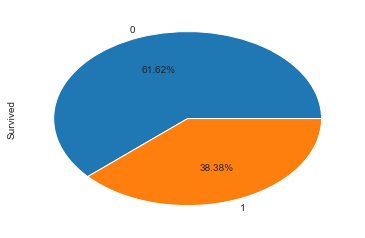

In [5]:
# Age,Cabin,Embarked,Fare存在缺失值
train_data['Survived'].value_counts().plot.pie(autopct='%1.2f%%')

In [6]:
# 二、缺失值处理
train_data.Embarked[train_data.Embarked.isnull()] = train_data.Embarked.dropna().mode().values #使用众数

In [7]:
train_data['Cabin'] = train_data.Cabin.fillna('U0')  #船舱使用U0代表缺失的值

In [8]:
# 使用回归、随机森林等模型来预测缺失属性的值，比如：年龄（一个非常重要的特征）
# 使用sklearn，要先把非数值特征转换为数值特征
from sklearn.ensemble import RandomForestRegressor
age_df = train_data[['Age','Survived','Fare','Parch','SibSp','Pclass']]
age_df_notnull = age_df.loc[(train_data['Age'].notnull())]
age_df_isnull = age_df.loc[(train_data['Age'].isnull())]
X = age_df_notnull.values[:,1:]
y = age_df_notnull.values[:,0]

RFR = RandomForestRegressor(n_estimators=1000,n_jobs=-1)
RFR.fit(X,y)
predictAges = RFR.predict(age_df_isnull.values[:,1:])
train_data.loc[train_data['Age'].isnull(),['Age']]  = predictAges

In [9]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            891 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          891 non-null object
Embarked       891 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB


In [10]:
# 三、分析数据之间的关系
# 1)性别与生存的关系 Sex
train_data.groupby(['Sex','Survived'])['Survived'].count()

Sex     Survived
female  0            81
        1           233
male    0           468
        1           109
Name: Survived, dtype: int64

(array([0, 1]), <a list of 2 Text xticklabel objects>)

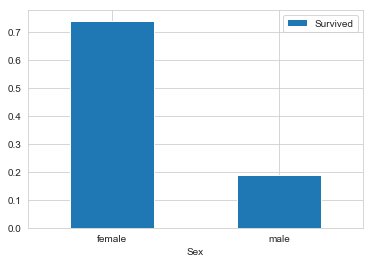

In [11]:
train_data[['Sex','Survived']].groupby(['Sex']).mean().plot.bar()
plt.xticks(rotation=0)
# 从结果可以看到，lady first

In [12]:
# 2)船舱等级和生存的关系 Pclass
train_data.groupby(['Pclass','Survived'])['Pclass'].count()

Pclass  Survived
1       0            80
        1           136
2       0            97
        1            87
3       0           372
        1           119
Name: Pclass, dtype: int64

(array([0, 1, 2]), <a list of 3 Text xticklabel objects>)

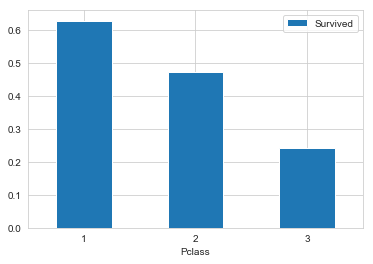

In [13]:
train_data[['Pclass','Survived']].groupby(['Pclass']).mean().plot.bar()
plt.xticks(rotation=0)

(array([0, 1, 2, 3, 4, 5]), <a list of 6 Text xticklabel objects>)

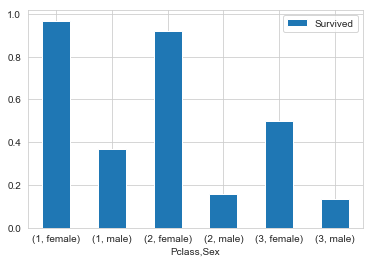

In [14]:
train_data[['Sex','Pclass','Survived']].groupby(['Pclass','Sex']).mean().plot.bar()
plt.xticks(rotation=0)
# 总体上看，妇女优先，不同船舱等级，也有一定的区别

In [15]:
train_data.groupby(['Sex','Pclass','Survived'])['Survived'].count()

Sex     Pclass  Survived
female  1       0             3
                1            91
        2       0             6
                1            70
        3       0            72
                1            72
male    1       0            77
                1            45
        2       0            91
                1            17
        3       0           300
                1            47
Name: Survived, dtype: int64

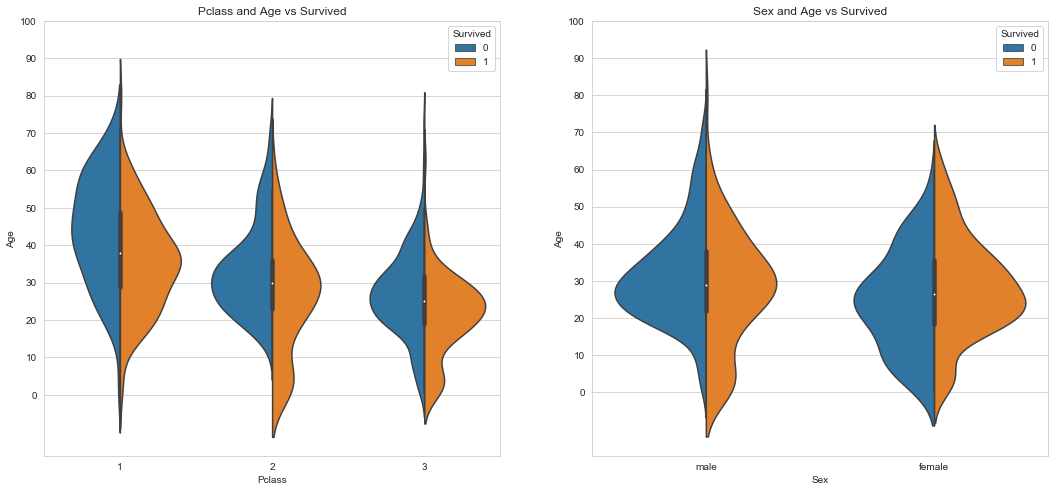

In [16]:
# 3）年龄与生存的关系   Age
# ①先看不同船舱等级和不同性别下年龄分布和生存的关系
fig,ax = plt.subplots(1,2,figsize=(18,8))
sns.violinplot('Pclass','Age',hue='Survived',data=train_data,split=True,ax=ax[0])
ax[0].set_title('Pclass and Age vs Survived')
ax[0].set_yticks(range(0,110,10))

sns.violinplot('Sex','Age',hue='Survived',data=train_data,split=True,ax=ax[1])
ax[1].set_title('Sex and Age vs Survived')
ax[1].set_yticks(range(0,110,10))

plt.show()

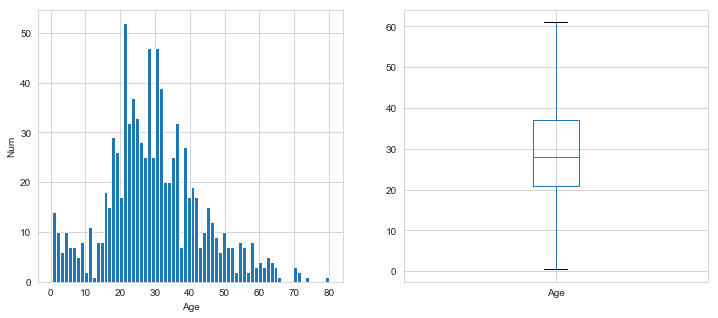

In [17]:
# ②分析总体的年龄分布
plt.figure(figsize=(12,5))
plt.subplot(121)
train_data['Age'].hist(bins=70)
plt.xlabel('Age')
plt.ylabel('Num')

plt.subplot(122)
train_data.boxplot(column='Age',showfliers=False)
plt.show()

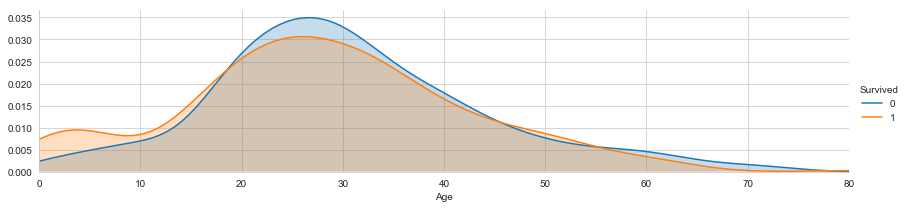

In [18]:
# ③不同年龄下的生存和非生存的分布情况：
facet = sns.FacetGrid(train_data,hue='Survived',aspect=4)
facet.map(sns.kdeplot,'Age',shade=True)
facet.set(xlim=(0,train_data['Age'].max()))
facet.add_legend()

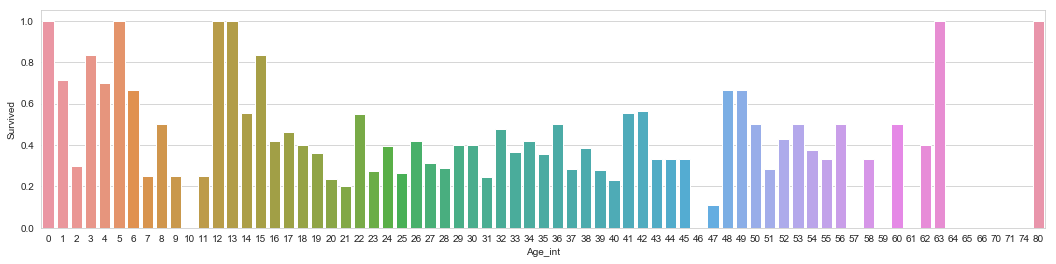

In [19]:
# ④不同年龄下的平均生存率：
fig,axis1 = plt.subplots(1,1,figsize=(18,4))
train_data['Age_int'] = train_data['Age'].astype(int)
average_age = train_data[['Age_int','Survived']].groupby(['Age_int'],as_index=False).mean()
sns.barplot(x='Age_int',y='Survived',data=average_age)

In [20]:
train_data['Age'].describe()

count    891.000000
mean      29.670759
std       13.741182
min        0.420000
25%       21.000000
50%       28.000000
75%       37.000000
max       80.000000
Name: Age, dtype: float64

In [21]:
# 按照年龄，将乘客划分为儿童、少年、成年和老年，分析4个群体的生存情况：
bins = [0,12,18,65,100]
train_data['Age_group'] = pd.cut(train_data['Age'],bins)
by_age = train_data.groupby('Age_group')['Survived'].mean()
by_age

Age_group
(0, 12]      0.506173
(12, 18]     0.466667
(18, 65]     0.364512
(65, 100]    0.125000
Name: Survived, dtype: float64

(array([0, 1, 2, 3]), <a list of 4 Text xticklabel objects>)

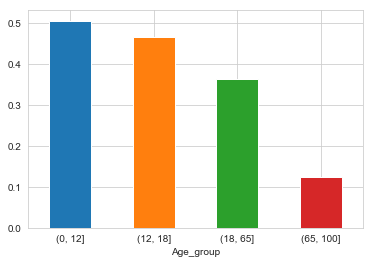

In [22]:
by_age.plot(kind='bar')
plt.xticks(rotation=0)

In [23]:
# 4)姓名与生存的关系 Name (一般来说，Name与预测值是没有直接关联的，但在此例中，使用姓名进行分析，确实能提升模型的效果)
train_data['Title'] = train_data['Name'].str.extract('([A-Za-z]+)\.',expand=False)
pd.crosstab(train_data['Title'],train_data['Sex'])

Sex,female,male
Title,,
Capt,0,1
Col,0,2
Countess,1,0
Don,0,1
Dr,1,6
Jonkheer,0,1
Lady,1,0
Major,0,2
Master,0,40


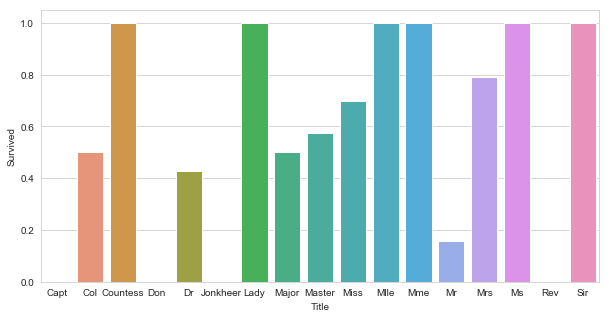

In [24]:
# ①分析不同称呼与生存的关系
# plt.figure(figsize=(10,5))
fig,ax1 = plt.subplots(1,1,figsize=(10,5))
a = train_data[['Title','Survived']].groupby(['Title'],as_index=False).mean()
sns.barplot(x='Title',y='Survived',data=a)
# sns这个包美化的是真好看

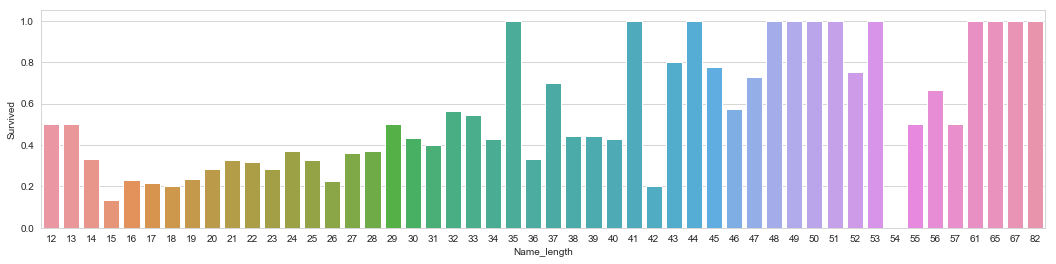

In [25]:
# ②分析名字长度与生存之间的关系  
fig,axis1 = plt.subplots(1,1,figsize=(18,4))
train_data['Name_length'] = train_data['Name'].apply(len)
name_length = train_data[['Name_length','Survived']].groupby(['Name_length'],as_index=False).mean()
sns.barplot(x='Name_length',y='Survived',data=name_length)
# 似乎有一定的关系

In [26]:
# 5）有无兄弟姐妹和生存的关系  SibSp
sibsp_df = train_data[train_data['SibSp'] != 0]
no_sibsp_df = train_data[train_data['SibSp'] == 0]

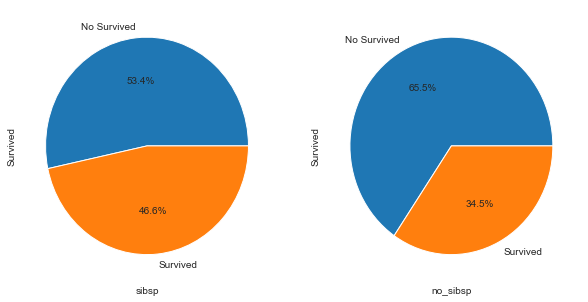

In [27]:
plt.figure(figsize=(10,5))
plt.subplot(121)
sibsp_df['Survived'].value_counts().plot.pie(labels=['No Survived','Survived'],autopct = '%1.1f%%')
plt.xlabel('sibsp')

plt.subplot(122)
no_sibsp_df['Survived'].value_counts().plot.pie(labels=['No Survived','Survived'],autopct = '%1.1f%%')
plt.xlabel('no_sibsp')
plt.show()

In [28]:
# 6)有无父母子女和生存的关系  Parch
parch_df = train_data[train_data['Parch'] != 0]
no_parch_df = train_data[train_data['Parch'] == 0]

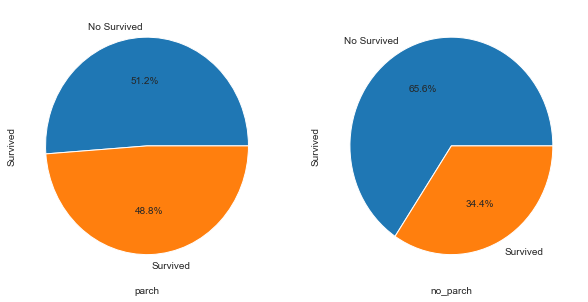

In [29]:
plt.figure(figsize=(10,5))
plt.subplot(121)
parch_df['Survived'].value_counts().plot.pie(labels=['No Survived','Survived'],autopct = '%1.1f%%')
plt.xlabel('parch')

plt.subplot(122)
no_parch_df['Survived'].value_counts().plot.pie(labels=['No Survived','Survived'],autopct = '%1.1f%%')
plt.xlabel('no_parch')

plt.show()

Text(0.5,1,'SibSp and Survived')

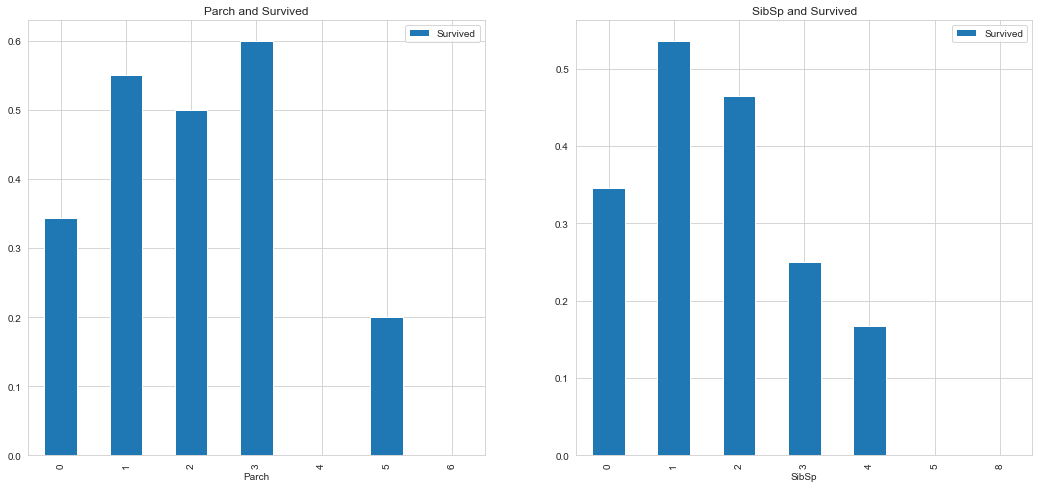

In [30]:
# 7)亲友的人数和生存的关系  SibSp & Parch
fi,ax = plt.subplots(1,2,figsize=(18,8))
train_data[['Parch','Survived']].groupby(['Parch']).mean().plot.bar(ax=ax[0])
ax[0].set_title('Parch and Survived')
train_data[['SibSp','Survived']].groupby(['SibSp']).mean().plot.bar(ax=ax[1])
ax[1].set_title('SibSp and Survived')

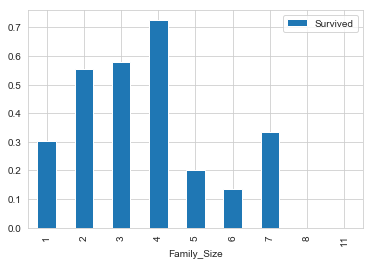

In [31]:
train_data['Family_Size'] = train_data['Parch'] + train_data['SibSp'] + 1
train_data[['Family_Size','Survived']].groupby(['Family_Size']).mean().plot.bar()
# 独自一人/亲友太多，存活率都会偏低

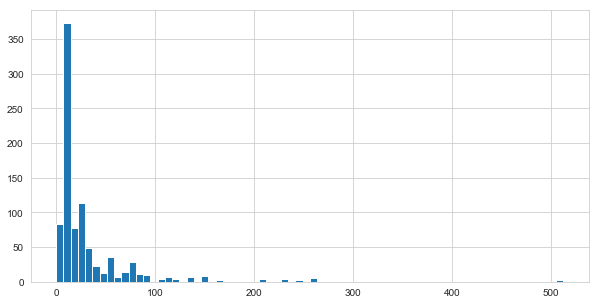

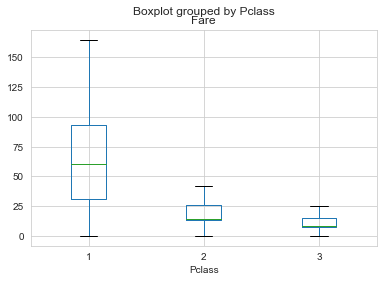

In [32]:
# 8）票价分布和生存的关系 Fare
plt.figure(figsize=(10,5))
train_data['Fare'].hist(bins=70)

train_data.boxplot(column='Fare',by='Pclass',showfliers=False)
plt.show()

In [33]:
train_data['Fare'].describe()

count    891.000000
mean      32.204208
std       49.693429
min        0.000000
25%        7.910400
50%       14.454200
75%       31.000000
max      512.329200
Name: Fare, dtype: float64

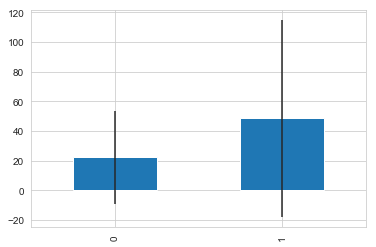

In [34]:
fare_not_survived = train_data['Fare'][train_data['Survived']==0]
fare_survived = train_data['Fare'][train_data['Survived']==1]

average_fare = pd.DataFrame([fare_not_survived.mean(),fare_survived.mean()])
std_fare = pd.DataFrame([fare_not_survived.std(),fare_survived.std()])
average_fare.plot(yerr=std_fare,kind='bar',legend=False)
plt.show()
# 票价与生否生还有一定的相关性，生还者的平均票价要大于未生还者的平均票价。

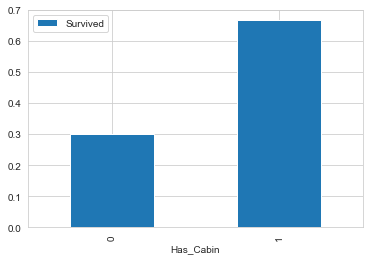

In [35]:
# 9）船舱类型和存货与否的关系  Cabin
# 由于船舱的缺失值太多，有效值只有204个，很难分析出不同的船舱和存活的关系，所以在做特征工程的时候，可以直接将该组特征丢弃
# ①这里先做一下分析，对于确实的数据都分为一类
train_data.loc[train_data.Cabin.isnull(),'Cabin'] = 'U0'
train_data['Has_Cabin'] = train_data['Cabin'].apply(lambda x: 0 if x == 'U0' else 1)
train_data[['Has_Cabin','Survived']].groupby(['Has_Cabin']).mean().plot.bar()

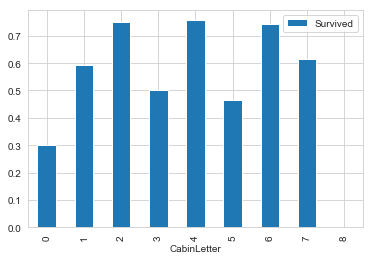

In [36]:
# ②对不同类型的船舱进行分析
train_data['CabinLetter'] = train_data['Cabin'].map(lambda x: re.compile('([a-zA-Z]+)').search(x).group())

train_data['CabinLetter'] = pd.factorize(train_data['CabinLetter'])[0]
train_data[['CabinLetter','Survived']].groupby(['CabinLetter']).mean().plot.bar()
# 不同的船舱生存率也有不同，但是差别不大。所以在处理中，可以直接将特征删除。

Text(0.5,1,'Embarked and Survived')

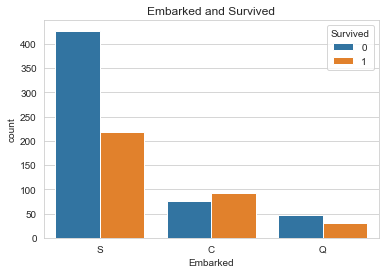

In [37]:
# 10）港口和存活与否的关系  Embarked
sns.countplot('Embarked',hue='Survived',data=train_data)
plt.title('Embarked and Survived')

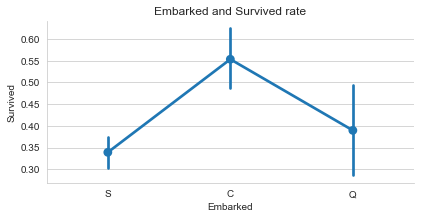

In [38]:
sns.factorplot('Embarked','Survived',data=train_data,size=3,aspect=2)
plt.title('Embarked and Survived rate')
plt.show()
# 在不同的港口上船，生还率不同，C最高，Q次之，S最低。

In [39]:
# 泰坦尼克号共有2224名乘客，训练数据只给出了891名乘客的信息，若训练数据是随机取样，则根据中心极限定理，分析结果会具有代表性
# 若不是随机选取，则分析结果就会有偏差。

In [40]:
# 四、变量转换
embark_dummies = pd.get_dummies(train_data['Embarked'])
train_data = train_data.join(embark_dummies)
train_data.drop(['Embarked'],axis=1,inplace=True)

In [41]:
embark_dummies = train_data[['S','C','Q']]
embark_dummies.head()

,S,C,Q
0,1,0,0
1,0,1,0
2,1,0,0
3,1,0,0
4,1,0,0


In [42]:
train_data['Cabin'][train_data.Cabin.isnull()] == 'U0'
train_data['CabinLetter'] = train_data['Cabin'].map(lambda x: re.compile('([a-zA-Z]+)').search(x).group())
train_data['CabinLetter'] = pd.factorize(train_data['CabinLetter'])[0]

In [43]:
train_data['CabinLetter'].head()

0    0
1    1
2    0
3    1
4    0
Name: CabinLetter, dtype: int64

In [44]:
from sklearn import preprocessing
assert np.size(train_data['Age']) == 891

In [45]:
scaler = preprocessing.StandardScaler()
train_data['Age_scaled'] = scaler.fit_transform(train_data['Age'].values.reshape(-1,1))

In [46]:
train_data['Fare_bin'] = pd.qcut(train_data['Fare'],5)
train_data['Fare_bin'].head()

0      (-0.001, 7.854]
1    (39.688, 512.329]
2        (7.854, 10.5]
3    (39.688, 512.329]
4        (7.854, 10.5]
Name: Fare_bin, dtype: category
Categories (5, interval[float64]): [(-0.001, 7.854] < (7.854, 10.5] < (10.5, 21.679] < (21.679, 39.688] < (39.688, 512.329]]

In [47]:
train_data['Fare_bin_id'] = pd.factorize(train_data['Fare_bin'])[0]
fare_bin_dummies_df = pd.get_dummies(train_data['Fare_bin']).rename(columns=lambda x:'Fare_' + str(x))
train_data = pd.concat([train_data,fare_bin_dummies_df],axis=1)

In [48]:
# 五、特征工程
train_df_org = pd.read_csv('data/train.csv')
test_df_org = pd.read_csv('data/test.csv')
test_df_org['Survived'] = 0
combined_train_test = train_df_org.append(test_df_org)
PassengerId = test_df_org['PassengerId']

In [49]:
# 1)Embarked
combined_train_test['Embarked'].fillna(combined_train_test['Embarked'].mode().iloc[0],inplace=True)

combined_train_test['Embarked'] = pd.factorize(combined_train_test['Embarked'])[0]

emb_dummies_df = pd.get_dummies(combined_train_test['Embarked'],prefix=combined_train_test[['Embarked']].columns[0])
combined_train_test = pd.concat([combined_train_test,emb_dummies_df],axis=1)

In [50]:
# 2）Sex   one-hot编码
combined_train_test['Sex'] = pd.factorize(combined_train_test['Sex'])[0]
sex_dummies_df = pd.get_dummies(combined_train_test['Sex'],prefix=combined_train_test[['Sex']].columns[0])
combined_train_test = pd.concat([combined_train_test,sex_dummies_df],axis=1)


In [51]:
# 3)Name
combined_train_test['Title'] = combined_train_test['Name'].map(lambda x: re.compile(',(.*?)\.').findall(x)[0])

In [52]:
combined_train_test['Title'].value_counts()

 Mr              757
 Miss            260
 Mrs             197
 Master           61
 Rev               8
 Dr                8
 Col               4
 Major             2
 Mlle              2
 Ms                2
 the Countess      1
 Capt              1
 Lady              1
 Don               1
 Sir               1
 Dona              1
 Mme               1
 Jonkheer          1
Name: Title, dtype: int64

In [53]:
title_Dict={}
title_Dict.update(dict.fromkeys(['Capt','Col','Major','Dr','Rev'],'Officer'))
title_Dict.update(dict.fromkeys(['Don','Sir','the Countess','Dona','Lady'],'Royalty'))
title_Dict.update(dict.fromkeys(['Mme','Ms','Mrs'],'Mrs'))
title_Dict.update(dict.fromkeys(['Mile','Miss'],'Miss'))
title_Dict.update(dict.fromkeys(['Mr'],'Mr'))
title_Dict.update(dict.fromkeys(['Master','Jonkheer'],'Master'))

combined_train_test['Title'] = combined_train_test['Title'].map(title_Dict)

In [54]:
combined_train_test['Title'] = pd.factorize(combined_train_test['Title'])[0]

title_dummies_df = pd.get_dummies(combined_train_test['Title'],prefix=combined_train_test[['Title']].columns[0])
combined_train_test = pd.concat([combined_train_test,title_dummies_df],axis=1)

In [55]:
# 增加名字长度的特征：
combined_train_test['Name_length'] = combined_train_test['Name'].apply(len)

In [56]:
# 4)Fare  测试集中缺失一个数据，按照一二三等舱各自的均价来填充
combined_train_test['Fare'] = combined_train_test[['Fare']].fillna(combined_train_test.groupby('Pclass').transform(np.mean))


In [57]:
# 通过对ticket数据的分析，可以看到部分票号数据有重复，同时结合亲属人数及名字的数据，和票价船舱等级对比，
# 可以知道购买的票中有家庭票和团体票，需要将团体票的票价分配到每个人的头上。
combined_train_test['Group_Ticket'] = combined_train_test['Fare'].groupby(by=combined_train_test['Ticket']).transform('count')
combined_train_test['Fare'] = combined_train_test['Fare'] / combined_train_test['Group_Ticket']
combined_train_test.drop(['Group_Ticket'],axis=1,inplace=True)

In [58]:
# 使用binning给票价分等级
combined_train_test['Fare_bin'] = pd.qcut(combined_train_test['Fare'],5)

In [59]:
# 对这5个等级的票价继续使用dummy：
combined_train_test['Fare_bin_id'] = pd.factorize(combined_train_test['Fare_bin'])[0]

fare_bin_dummies_df = pd.get_dummies(combined_train_test['Fare_bin_id']).rename(columns=lambda x: 'Fare_' + str(x))
combined_train_test.drop(['Fare_bin'],axis=1,inplace=True)

In [60]:
# 5)Pclass
# 假设对于不同等级的船舱，各船舱内部的票价也说明了各等级舱的位置，那么也就有可能与逃生的顺序有关系，所以这里分出每个等级舱的高价和低价位
from sklearn.preprocessing import LabelEncoder

def pclass_fare_category(df,pclass1_mean_fare,pclass2_mean_fare,pclass3_mean_fare):
    if df['Pclass'] == 1:
        if df['Fare'] <= pclass1_mean_fare:
            return 'Pclass1_Low'
        else:
            return 'Pclass1_High'
    elif df['Pclass'] == 2:
        if df['Fare'] <= pclass2_mean_fare:
            return 'Pclass2_Low'
        else:
            return 'Pclass2_High'
    elif df['Pclass'] == 3:
        if df['Fare'] <= pclass3_mean_fare:
            return 'Pclass3_Low'
        else:
            return 'Pclass3_High'
        
Pclass1_mean_fare = combined_train_test['Fare'].groupby(by=combined_train_test['Pclass']).mean().get([1]).values[0]
Pclass2_mean_fare = combined_train_test['Fare'].groupby(by=combined_train_test['Pclass']).mean().get([2]).values[0]
Pclass3_mean_fare = combined_train_test['Fare'].groupby(by=combined_train_test['Pclass']).mean().get([3]).values[0]

combined_train_test['Pclass_Fare_Category'] = combined_train_test.apply(pclass_fare_category,args=(
    Pclass1_mean_fare,Pclass2_mean_fare,Pclass3_mean_fare),axis=1)

pclass_level = LabelEncoder()

pclass_level.fit(np.array(['Pclass1_Low','Pclass1_High','Pclass2_Low','Pclass2_High','Pclass3_Low','Pclass3_High']))

combined_train_test['Pclass_Fare_Category'] = pclass_level.transform(combined_train_test['Pclass_Fare_Category'])

pclass_dummies_df = pd.get_dummies(combined_train_test['Pclass_Fare_Category']).rename(columns=lambda x:'Pclass_' + str(x))
combined_train_test = pd.concat([combined_train_test,pclass_dummies_df],axis=1)


In [61]:
combined_train_test['Pclass'] = pd.factorize(combined_train_test['Pclass'])[0]

In [62]:
# 6)Parch and SibSp
def family_size_category(family_size):
    if family_size <= 1:
        return 'Single'
    elif family_size <= 4:
        return 'Small_Family'
    else:
        return 'Large_Family'

combined_train_test['Family_Size'] = combined_train_test['Parch'] + combined_train_test['SibSp'] + 1
combined_train_test['Family_Size_Category'] = combined_train_test['Family_Size'].map(family_size_category)

le_family = LabelEncoder()
le_family.fit(np.array(['Single','Small_Family','Large_Family']))
combined_train_test['Family_Size_Category'] = le_family.transform(combined_train_test['Family_Size_Category'])

family_size_dummies_df = pd.get_dummies(combined_train_test['Family_Size_Category'],
                                        prefix=combined_train_test[['Family_Size_Category']].columns[0])
combined_train_test = pd.concat([combined_train_test,family_size_dummies_df],axis=1)

In [63]:
# 7)Age
# 两种年龄填充方式：一种是根据Title中的称呼，根据不同类别的平均年龄来填充
# 另外一种是综合几项如Sex,Title,Pclass等其他没有缺失值的向，使用ml算法来预测age
missing_age_df = pd.DataFrame(combined_train_test[
    ['Age','Embarked','Sex','Title','Name_length','Family_Size','Family_Size_Category','Fare','Fare_bin_id','Pclass']])

missing_age_train = missing_age_df[missing_age_df['Age'].notnull()]
missing_age_test = missing_age_df[missing_age_df['Age'].isnull()]

In [64]:
from sklearn import ensemble
from sklearn import model_selection
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor

def fill_missing_age(missing_age_train,missing_age_test):
    missing_age_X_train = missing_age_train.drop(['Age'],axis=1)
    missing_age_y_train = missing_age_train['Age']
    missing_age_X_test = missing_age_test.drop(['Age'],axis=1)
    
    gbm_reg = GradientBoostingRegressor(random_state=23)
    gbm_reg_param_grid = {'n_estimators':[2000],'max_depth':[4],'learning_rate':[0.01],'max_features':[3]}
    gbm_reg_grid = model_selection.GridSearchCV(gbm_reg,gbm_reg_param_grid,cv=10,n_jobs=-1,verbose=1,scoring='neg_mean_squared_error')
    gbm_reg_grid.fit(missing_age_X_train,missing_age_y_train)
    print('Age feature Best GB Params:' + str(gbm_reg_grid.best_params_))
    print('Age feature Best GB Score:' + str(gbm_reg_grid.best_score_))
    print('GB Train Error for "Age" Feature Regressor:' + str(gbm_reg_grid.score(missing_age_X_train,missing_age_y_train)))
    missing_age_test.loc[:,'Age_GB'] = gbm_reg_grid.predict(missing_age_X_test)
    print(missing_age_test['Age_GB'][:4])
    
    rf_reg = RandomForestRegressor()
    rf_reg_param_grid = {'n_estimators':[200],'max_depth':[5],'random_state':[0]}
    rf_reg_grid = model_selection.GridSearchCV(rf_reg,rf_reg_param_grid,cv=10,n_jobs=-1,verbose=1,scoring='neg_mean_squared_error')
    rf_reg_grid.fit(missing_age_X_train,missing_age_y_train)
    print('Age feature Best RF Params:' + str(rf_reg_grid.best_params_))
    print('Age feature Best RF Score:' + str(rf_reg_grid.best_score_))
    print('RF Train Error for "Age" Fearure Regressor' + str(rf_reg_grid.score(missing_age_X_train,missing_age_y_train)))
    missing_age_test.loc[:,'Age_RF'] = rf_reg_grid.predict(missing_age_X_test)
    print(missing_age_test['Age_RF'][:4])
    
    print('shape1',missing_age_test['Age'].shape,missing_age_test[['Age_GB','Age_RF']].mode(axis=1).shape)
    
    missing_age_test.loc[:,'Age'] = np.mean([missing_age_test['Age_GB'],missing_age_test['Age_RF']])
    print(missing_age_test['Age'][:4])
    
    missing_age_test.drop(['Age_GB','Age_RF'],axis=1,inplace=True)
    
    return missing_age_test

In [65]:
combined_train_test.loc[(combined_train_test.Age.isnull()),'Age'] = fill_missing_age(missing_age_train,missing_age_test)


Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   6 out of  10 | elapsed:    4.0s remaining:    2.6s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    5.2s finished
C:\tcl\Anaconda\envs\py3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Age feature Best GB Params:{'learning_rate': 0.01, 'max_depth': 4, 'max_features': 3, 'n_estimators': 2000}
Age feature Best GB Score:-157.27590216530936
GB Train Error for "Age" Feature Regressor:-75.52885330764825
5     35.860195
17    32.832031
19    22.573744
26    28.670563
Name: Age_GB, dtype: float64
Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   6 out of  10 | elapsed:    0.6s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    1.0s finished
C:\tcl\Anaconda\envs\py3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Age feature Best RF Params:{'max_depth': 5, 'n_estimators': 200, 'random_state': 0}
Age feature Best RF Score:-146.19849925683152
RF Train Error for "Age" Fearure Regressor-116.50268319784635
5     31.001134
17    33.725938
19    25.427105
26    27.893547
Name: Age_RF, dtype: float64
shape1 (263,) (263, 2)
5     29.749776
17    29.749776
19    29.749776
26    29.749776
Name: Age, dtype: float64


In [66]:
# 8)Ticket
combined_train_test['Ticket_Letter'] = combined_train_test['Ticket'].str.split().str[0]
combined_train_test['Ticket_Letter'] = combined_train_test['Ticket_Letter'].apply(lambda x:'U0' if x.isnumeric() else x)

combined_train_test['Ticket_Letter'] = pd.factorize(combined_train_test['Ticket_Letter'])[0]

In [67]:
# 9)Cabin
combined_train_test.loc[combined_train_test.Cabin.isnull(),'Cabin'] = 'U0'
combined_train_test['Cabin'] = combined_train_test['Cabin'].apply(lambda x: 0 if x=='U0' else 1)

In [68]:
# 特征间相关性分析
Correlation = pd.DataFrame(combined_train_test[
    ['Embarked','Sex','Title','Name_length','Family_Size','Family_Size_Category','Fare','Fare_bin_id',
    'Pclass','Pclass_Fare_Category','Age','Ticket_Letter','Cabin']])

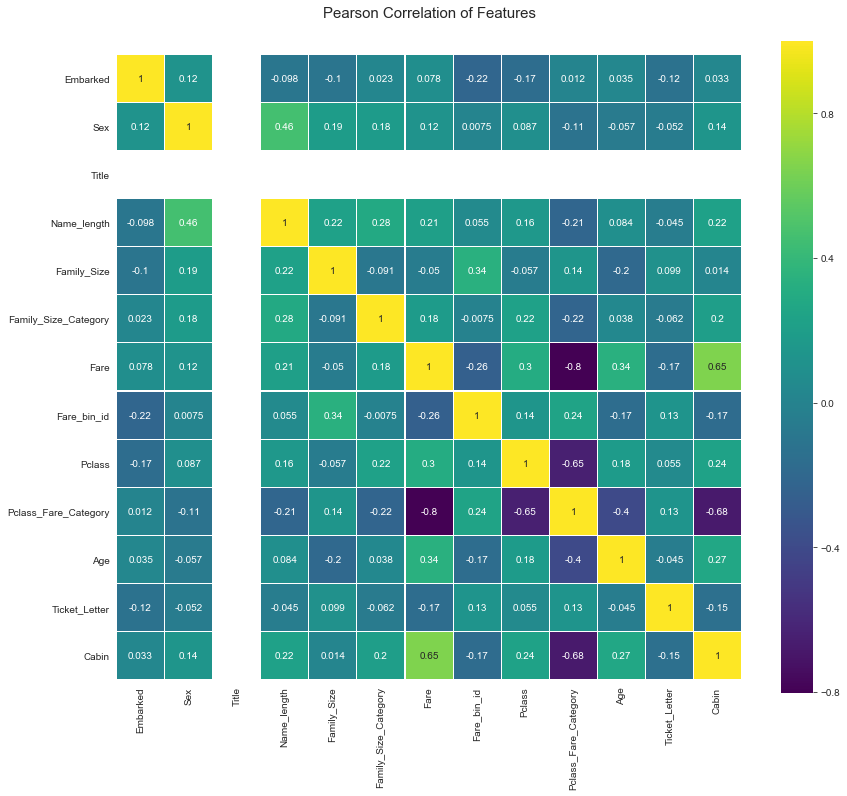

In [69]:
colormap = plt.cm.viridis
plt.figure(figsize=(14,12))
plt.title('Pearson Correlation of Features',y=1.05,size=15)
sns.heatmap(Correlation.astype(float).corr(),linewidths=0.1,vmax=1.0,square=True,cmap=colormap,linecolor='white',annot=True)


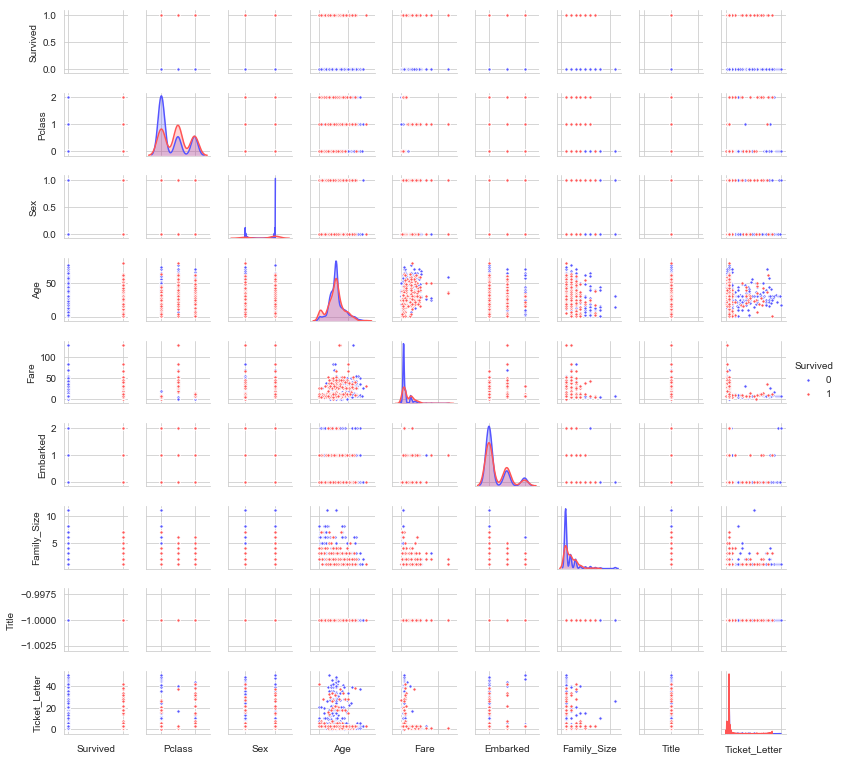

In [70]:
# 特征之间数据分布图
g = sns.pairplot(combined_train_test[[u'Survived',u'Pclass',u'Sex',u'Age',u'Fare',u'Embarked',u'Family_Size',u'Title',u'Ticket_Letter']],
                 hue='Survived',palette='seismic',size=1.2,diag_kind='kde',diag_kws=dict(shade=True),plot_kws=dict(s=10))
g.set(xticklabels=[])

In [71]:
# 输入模型前的一些处理
# 1）数据标准化 (Age,fare)
scale_age_fare = preprocessing.StandardScaler().fit(combined_train_test[['Age','Fare','Name_length']])
combined_train_test[['Age','Fare','Name_length']] = scale_age_fare.transform(combined_train_test[['Age','Fare','Name_length']])

# 2)放弃无用特征
# 先备份
combined_data_backup = combined_train_test
combined_train_test.drop(['PassengerId','Embarked','Sex','Name','Title','Fare_bin_id','Pclass_Fare_Category','Parch','SibSp','Family_Size_Category','Ticket'],axis=1,inplace=True)

# 3)将训练数据和测试数据分开
train_data = combined_train_test[:891]
test_data = combined_train_test[891:]

titanic_train_data_X = train_data.drop(['Survived'],axis=1)
titanic_train_data_y = train_data['Survived']
titanic_test_data_X = test_data.drop(['Survived'],axis=1)

In [72]:
titanic_train_data_X.shape

(891, 22)

In [87]:
# 六、模型融合及测试
# 1）利用不同模型对特征进行筛选，选出较为重要的特征
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier

def get_top_n_features(titanic_train_data_X,titanic_train_data_y,top_n_features):
    
    # random forest
    rf_est = RandomForestClassifier(random_state=0)
    rf_param_grid = {'n_estimators':[500],'min_samples_split':[2,3],'max_depth':[20]}
    rf_grid = model_selection.GridSearchCV(rf_est,rf_param_grid,n_jobs=-1,cv=10,verbose=1)
    rf_grid.fit(titanic_train_data_X,titanic_train_data_y)
    print('Top N Features Best RF Params:' + str(rf_grid.best_params_))
    print('Top N Features Best RF Score:' + str(rf_grid.best_score_))
    print('Top N Features RF Train Score:' + str(rf_grid.score(titanic_train_data_X,titanic_train_data_y)))
    feature_imp_sorted_rf = pd.DataFrame({'feature':list(titanic_train_data_X),
                                          'importance':rf_grid.best_estimator_.feature_importances_}).sort_values('importance',ascending=False)
    features_top_n_rf = feature_imp_sorted_rf.head(top_n_features)['feature']
    print('Sample 10 Features from RF Classifier:')
    print(str(features_top_n_rf[:10]))
    
    # AdaBoost
    ada_est = AdaBoostClassifier(random_state=0)
    ada_param_grid = {'n_estimators':[500],'learning_rate':[0.01,0.1]}
    ada_grid = model_selection.GridSearchCV(ada_est,ada_param_grid,n_jobs=-1,cv=10,verbose=1)
    ada_grid.fit(titanic_train_data_X,titanic_train_data_y)
    print('Top N Features Best Ada Params:' + str(ada_grid.best_params_))
    print('Top N Features Best Ada score:' + str(ada_grid.best_score_))
    print('Top N Features Ada Train Score:' + str(ada_grid.score(titanic_train_data_X,titanic_train_data_y)))
    feature_imp_sorted_ada = pd.DataFrame({'feature':list(titanic_train_data_X),
                                          'importance':ada_grid.best_estimator_.feature_importances_}).sort_values('importance',ascending=False)
    features_top_n_ada = feature_imp_sorted_ada.head(top_n_features)['feature']
    print('Sample 10 Features from Ada Classifier:')
    print(str(features_top_n_ada[:10]))
    
    # ExtraTree
    et_est = ExtraTreesClassifier(random_state=0)
    et_param_grid = {'n_estimators':[500],'min_samples_split':[3,4],'max_depth':[20]}
    et_grid = model_selection.GridSearchCV(et_est,et_param_grid,n_jobs=-1,cv=10,verbose=1)
    et_grid.fit(titanic_train_data_X,titanic_train_data_y)
    print('Top N Features Best ET Params:' + str(et_grid.best_params_))
    print('Top N Features Best ET score:' + str(et_grid.best_score_))
    print('Top N Features ET Train Score:' + str(et_grid.score(titanic_train_data_X,titanic_train_data_y)))
    feature_imp_sorted_et= pd.DataFrame({'feature':list(titanic_train_data_X),
                                          'importance':et_grid.best_estimator_.feature_importances_}).sort_values('importance',ascending=False)
    features_top_n_et = feature_imp_sorted_et.head(top_n_features)['feature']
    print('Sample 10 Features from ET Classifier:')
    print(str(features_top_n_et[:10]))
    
    # GradientBoosting
    gb_est = GradientBoostingClassifier(random_state=0)
    gb_param_grid = {'n_estimators':[500],'learning_rate':[0.01,0.1],'max_depth':[20]}
    gb_grid = model_selection.GridSearchCV(gb_est,gb_param_grid,n_jobs=-1,cv=10,verbose=1)
    gb_grid.fit(titanic_train_data_X,titanic_train_data_y)
    print('Top N Features Best GB Params:' + str(gb_grid.best_params_))
    print('Top N Features Best GB score:' + str(gb_grid.best_score_))
    print('Top N Features GB Train Score:' + str(gb_grid.score(titanic_train_data_X,titanic_train_data_y)))
    feature_imp_sorted_gb= pd.DataFrame({'feature':list(titanic_train_data_X),
                                          'importance':gb_grid.best_estimator_.feature_importances_}).sort_values('importance',ascending=False)
    features_top_n_gb = feature_imp_sorted_gb.head(top_n_features)['feature']
    print('Sample 10 Features from GB Classifier:')
    print(str(features_top_n_gb[:10]))
    
    # DecisionTree
    dt_est = DecisionTreeClassifier(random_state=0)
    dt_param_grid = {'min_samples_split':[2,4],'max_depth':[20]}
    dt_grid = model_selection.GridSearchCV(dt_est,dt_param_grid,n_jobs=-1,cv=10,verbose=1)
    dt_grid.fit(titanic_train_data_X,titanic_train_data_y)
    print('Top N Features Best DT Params:' + str(dt_grid.best_params_))
    print('Top N Features Best DT score:' + str(dt_grid.best_score_))
    print('Top N Features DT Train Score:' + str(dt_grid.score(titanic_train_data_X,titanic_train_data_y)))
    feature_imp_sorted_dt= pd.DataFrame({'feature':list(titanic_train_data_X),
                                          'importance':dt_grid.best_estimator_.feature_importances_}).sort_values('importance',ascending=False)
    features_top_n_dt = feature_imp_sorted_dt.head(top_n_features)['feature']
    print('Sample 10 Features from DT Classifier:')
    print(str(features_top_n_dt[:10]))
    
    # merge the three models
    features_top_n = pd.concat([features_top_n_rf,features_top_n_ada,features_top_n_et,features_top_n_gb,features_top_n_dt],
                              ignore_index=True).drop_duplicates()
    features_importance = pd.concat([feature_imp_sorted_rf,feature_imp_sorted_ada,feature_imp_sorted_et,
                                    feature_imp_sorted_gb,feature_imp_sorted_dt],ignore_index=True)
    
    return features_top_n,features_importance
    

In [88]:
# 2)依据筛选出的特征构建训练集和测试集
feature_to_pick=30
feature_top_n,feature_importance = get_top_n_features(titanic_train_data_X,titanic_train_data_y,feature_to_pick)
titanic_train_data_X = pd.DataFrame(titanic_train_data_X[feature_top_n])
titanic_test_data_X = pd.DataFrame(titanic_test_data_X[feature_top_n])

Fitting 10 folds for each of 2 candidates, totalling 20 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:    4.7s finished


Top N Features Best RF Params:{'max_depth': 20, 'min_samples_split': 2, 'n_estimators': 500}
Top N Features Best RF Score:0.8237934904601572
Top N Features RF Train Score:0.9966329966329966
Sample 10 Features from RF Classifier:
10               Name_length
0                        Age
2                       Fare
8                      Sex_1
7                      Sex_0
3                     Pclass
21             Ticket_Letter
17               Family_Size
1                      Cabin
20    Family_Size_Category_2
Name: feature, dtype: object
Fitting 10 folds for each of 2 candidates, totalling 20 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:    5.1s finished


Top N Features Best Ada Params:{'learning_rate': 0.1, 'n_estimators': 500}
Top N Features Best Ada score:0.8103254769921436
Top N Features Ada Train Score:0.8383838383838383
Sample 10 Features from Ada Classifier:
0               Age
10      Name_length
2              Fare
21    Ticket_Letter
17      Family_Size
7             Sex_0
8             Sex_1
3            Pclass
4        Embarked_0
1             Cabin
Name: feature, dtype: object
Fitting 10 folds for each of 2 candidates, totalling 20 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:    4.6s finished


Top N Features Best ET Params:{'max_depth': 20, 'min_samples_split': 4, 'n_estimators': 500}
Top N Features Best ET score:0.8237934904601572
Top N Features ET Train Score:0.9730639730639731
Sample 10 Features from ET Classifier:
7                      Sex_0
8                      Sex_1
10               Name_length
0                        Age
2                       Fare
1                      Cabin
21             Ticket_Letter
3                     Pclass
20    Family_Size_Category_2
17               Family_Size
Name: feature, dtype: object
Fitting 10 folds for each of 2 candidates, totalling 20 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:   17.7s finished


Top N Features Best GB Params:{'learning_rate': 0.1, 'max_depth': 20, 'n_estimators': 500}
Top N Features Best GB score:0.7710437710437711
Top N Features GB Train Score:0.9966329966329966
Sample 10 Features from GB Classifier:
0                        Age
7                      Sex_0
2                       Fare
10               Name_length
8                      Sex_1
3                     Pclass
1                      Cabin
20    Family_Size_Category_2
17               Family_Size
21             Ticket_Letter
Name: feature, dtype: object
Fitting 10 folds for each of 2 candidates, totalling 20 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  20 | elapsed:    0.0s remaining:    0.2s


Top N Features Best DT Params:{'max_depth': 20, 'min_samples_split': 4}
Top N Features Best DT score:0.7497194163860831
Top N Features DT Train Score:0.9663299663299664
Sample 10 Features from DT Classifier:
7                      Sex_0
0                        Age
2                       Fare
10               Name_length
3                     Pclass
1                      Cabin
17               Family_Size
20    Family_Size_Category_2
21             Ticket_Letter
5                 Embarked_1
Name: feature, dtype: object


[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:    0.1s finished


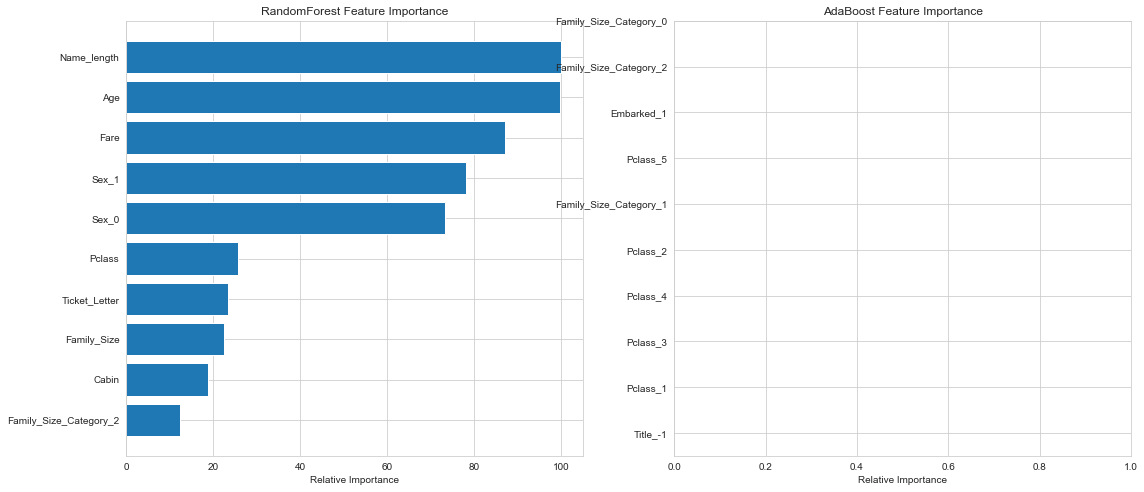

In [99]:
# 可视化
rf_feature_imp = feature_importance[:10]
Ada_feature_imp = feature_importance[32:32+10].reset_index(drop=True)

rf_feature_importance = 100.0 * (rf_feature_imp['importance'] / rf_feature_imp['importance'].max())
Ada_feature_importance = 100.0 * (Ada_feature_imp['importance'] / Ada_feature_imp['importance'].max())

rf_important_idx = np.where(rf_feature_importance)[0]
Ada_important_idx = np.where(Ada_feature_importance)[0]

pos = np.arange(rf_important_idx.shape[0]) + .5

plt.figure(1,figsize=(18,8))

plt.subplot(121)
plt.barh(pos,rf_feature_importance[rf_important_idx][::-1])
plt.yticks(pos,rf_feature_imp['feature'][::-1])
plt.xlabel('Relative Importance')
plt.title('RandomForest Feature Importance')

plt.subplot(122)
# plt.barh(pos,Ada_feature_importance[Ada_important_idx][::-1])
plt.yticks(pos,Ada_feature_imp['feature'][::-1])
plt.xlabel('Relative Importance')
plt.title('AdaBoost Feature Importance')

plt.show()

In [ ]:
# 3)模型融合
# Bagging,Boosting,Stacking,Blending
# ①Bagging:多个模型的结果进行加权/投票   （多个基分类器的线性组合）
# ②Boosting:在一个弱学习器的基础上，对错误进行弥补   AdaBoost,Gradient Boost
# ③Stacking:多个基分类器的非线性组合 （把学习器一层一层堆砌起来，形成网状结构）
# ④Blending:

In [102]:
# Stacking：
# Level1: 对每个基学习器使用K-fold，将K个模型对Valid set的预测结果拼起来，作为下一层学习器的输入。
from sklearn.model_selection import KFold

ntrain = titanic_train_data_X.shape[0]
ntest = titanic_test_data_X.shape[0]
seed = 0
nfolds = 7
kf = KFold(n_splits = nfolds,random_state=seed,shuffle=False)

# 定义一个方法，输出k-fold预测
def get_out_fold(clf,x_train,y_train,x_test):
    oof_train = np.zeros((ntrain,))
    oof_test = np.zeros((ntest,))
    oof_test_skf = np.empty((nfolds,ntest))
    
    for i,(train_index,test_index) in enumerate(kf.split(x_train)):
        x_tr = x_train[train_index]
        y_tr = y_train[train_index]
        x_te = x_train[test_index]
        
        clf.fit(x_tr,y_tr)
        
        oof_train[test_index] = clf.predict(x_te)
        oof_test_skf[i,:] = clf.predict(x_test)
        
    oof_test[:] = oof_test_skf.mean(axis=0)
    return oof_train.reshape(-1,1),oof_test.reshape(-1,1)

In [103]:
# 构建不同的基学习器，使用RandomForest,AdaBoost,ExtraTrees,GBDT,DecisionTree,KNN,SVM
# (可以用GridSearch对模型的超参数进行搜索选择)

from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC

rf = RandomForestClassifier(n_estimators=500,warm_start=True,max_features='sqrt',max_depth=6,
                           min_samples_split=3,min_samples_leaf=2,n_jobs=-1,verbose=0)

ada = AdaBoostClassifier(n_estimators=500,learning_rate=0.1)

et = ExtraTreesClassifier(n_estimators=500,n_jobs=-1,max_depth=8,min_samples_leaf=2,verbose=0)

gb = GradientBoostingClassifier(n_estimators=500,learning_rate=0.008,min_samples_split=3,min_samples_leaf=2,
                                max_depth=5,verbose=0)

dt = DecisionTreeClassifier(max_depth=8)

knn = KNeighborsClassifier(n_neighbors=2)

svm = SVC(kernel='linear',C=0.025)

In [104]:
x_train = titanic_train_data_X.values
x_test = titanic_test_data_X.values
y_train = titanic_train_data_y.values

In [107]:
rf_oof_train,rf_oof_test = get_out_fold(rf,x_train,y_train,x_test)
ada_oof_train,ada_oof_test = get_out_fold(ada,x_train,y_train,x_test)
et_oof_train,et_oof_test = get_out_fold(et,x_train,y_train,x_test)
gb_oof_train,gb_oof_test = get_out_fold(gb,x_train,y_train,x_test)
dt_oof_train,dt_oof_test = get_out_fold(dt,x_train,y_train,x_test)
knn_oof_train,knn_oof_test = get_out_fold(knn,x_train,y_train,x_test)
svm_oof_train,svm_oof_test = get_out_fold(svm,x_train,y_train,x_test)

print('Training is complete')

Training is complete


In [109]:
# 4）预测并生成提交文件
# level2：利用XGBoost,使用第一层预测的结果作为特征对最终的结果进行预测
x_train = np.concatenate((rf_oof_train,ada_oof_train,et_oof_train,gb_oof_train,dt_oof_train,knn_oof_train,svm_oof_train),axis=1)
x_test = np.concatenate((rf_oof_test,ada_oof_test,et_oof_test,gb_oof_test,dt_oof_test,knn_oof_test,svm_oof_test),axis=1)


In [111]:
from xgboost import XGBClassifier
gbm = XGBClassifier(n_estimators=2000,max_depth=4,min_child_weight=2,gamma=0.9,subsample=0.8,
                   colsample_bytree=0.8,objective='binary:logistic',nthread=-1,scale_pos_weight=1).fit(x_train,y_train)
predictions=gbm.predict(x_test)

In [112]:
StackingSubmission = pd.DataFrame({'PassengerId':PassengerId,'Survived':predictions})
# StackingSubmission.to_csv('output/StackingSubmission.csv',index=False,sep=',')